In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('CE.BC.E.up-to-o3.csv')
data.loc[:, 'Energy'] *= 1e-6 # Convert energy to Joules
data.head()

,Benchmark,Flags,Energy,Time,Success
0,sp.C.x,-O3,14282.683057,67.507678,True
1,sp.C.x,-O3,15273.536836,70.879422,True
2,sp.C.x,-O3,15844.272017,74.863096,True
3,sp.C.x,-O1 -falign-functions -falign-jumps -falign-la...,14810.540320,68.005251,True
4,sp.C.x,-O1 -falign-functions -falign-jumps -falign-la...,15678.612420,73.026502,True


In [3]:
average_data = data.groupby(['Benchmark','Flags'], as_index=False).agg({'Energy':'mean', 'Time':'mean'})

In [4]:
benchmarks = data["Benchmark"].unique()
print(benchmarks)

['sp.C.x' 'ua.C.x' 'bt.C.x' 'is.C.x' 'mg.C.x' 'cg.C.x' 'ep.C.x' 'ft.C.x'
 'lu.C.x']


### Find best configuration for Energy

In [5]:
def best_configuration(variable, benchmark, average_data):
    benchmark_data = average_data.loc[average_data["Benchmark"] == benchmark]
    min_index = benchmark_data[variable].idxmin()
    return benchmark_data.loc[min_index]["Flags"]
    

In [12]:
for benchmark in benchmarks:
    print(benchmark)
    print(best_configuration('Energy', benchmark, average_data))
    print('-----')

sp.C.x
-O1 -falign-functions -falign-jumps -falign-labels -falign-loops -fbranch-count-reg -fcaller-saves -fcode-hoisting -fcombine-stack-adjustments -fcompare-elim -fcprop-registers -fcrossjumping -fcse-follow-jumps -fdefer-pop -fdevirtualize -fdevirtualize-speculatively -fexpensive-optimizations -fforward-propagate -fgcse -fgcse-after-reload -fguess-branch-probability -fhoist-adjacent-loads -fif-conversion -fif-conversion2 -findirect-inlining -finline-functions -finline-functions-called-once -finline-small-functions -fipa-bit-cp -fipa-cp -fipa-cp-clone -fipa-icf -fipa-icf-functions -fipa-icf-variables -fipa-profile -fipa-pure-const -fipa-ra -fipa-reference -fipa-sra -fipa-vrp -fisolate-erroneous-paths-dereference -flra-remat -fmove-loop-invariants -foptimize-sibling-calls -foptimize-strlen -fpartial-inlining -fpeel-loops -fpeephole2 -fpredictive-commoning -freorder-blocks -freorder-blocks-and-partition -freorder-functions -frerun-cse-after-loop -fschedule-insns2 -fshrink-wrap -fsplit

### Compare Energy vs Time

In [13]:
def plot_energy_vs_time(benchmark, data):
    benchmark_data = data.loc[data["Benchmark"] == benchmark]
    
    X = benchmark_data["Time"].values
    Y = benchmark_data["Energy"].values
    
    plt.figure()
    plt.scatter(X, Y)
    plt.title('Energy vs Time results for Combined Elimination on ' + benchmark)
    plt.xlabel('Time (s)')
    plt.ylabel('Energy (J)')

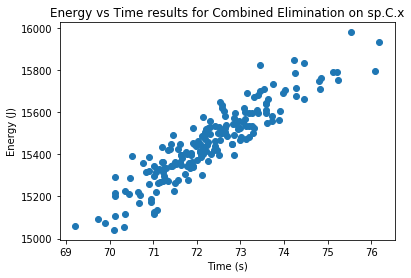

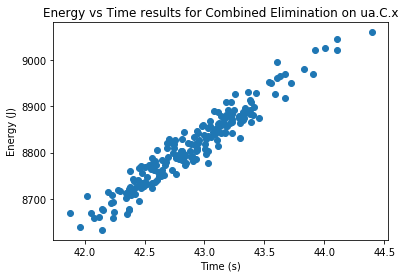

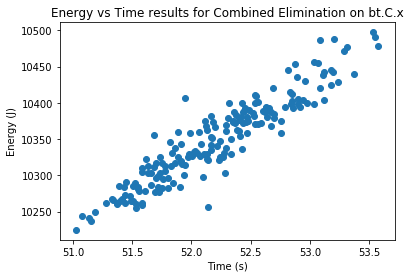

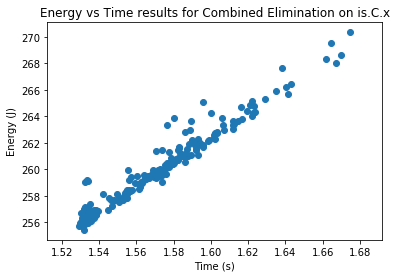

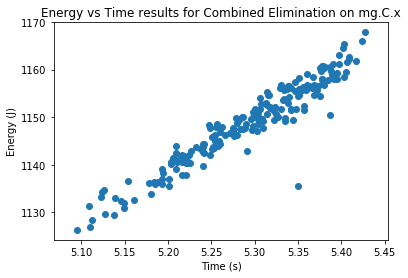

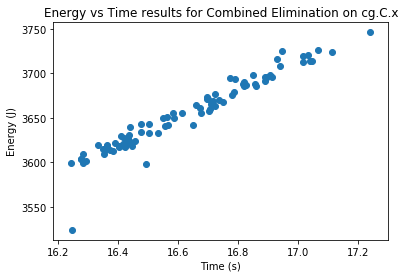

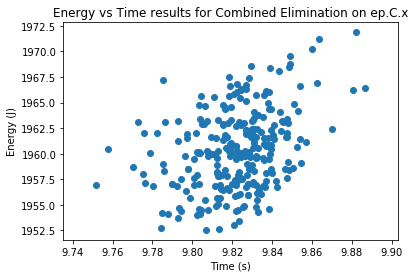

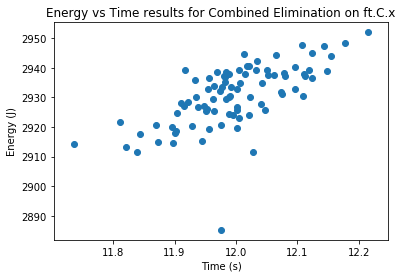

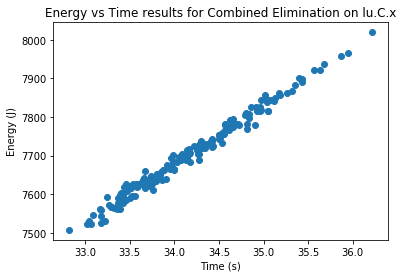

In [8]:
for benchmark in benchmarks:
    plot_energy_vs_time(benchmark, average_data)

### Compare Energy vs Runs

In [15]:
def plot_energy_vs_runs(benchmark, data):
    benchmark_data = data.loc[data["Benchmark"] == benchmark]
    
    num_runs = len(benchmark_data)
    
    X = np.arange(1, num_runs + 1)
    Y = benchmark_data["Energy"].values
    
    plt.figure()
    plt.plot(X, Y)
    plt.title('Energy vs run id for Combined Elimination on ' + benchmark)
    plt.xlabel('Run Id')
    plt.ylabel('Energy (J())')

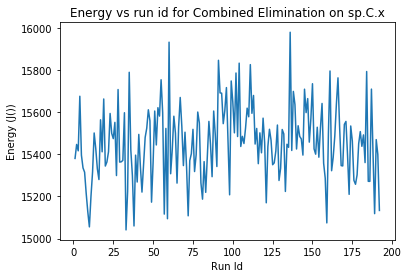

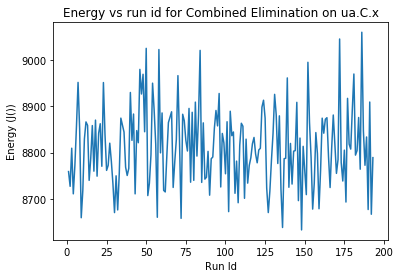

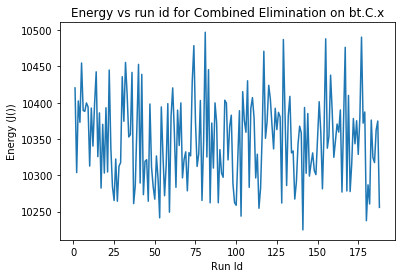

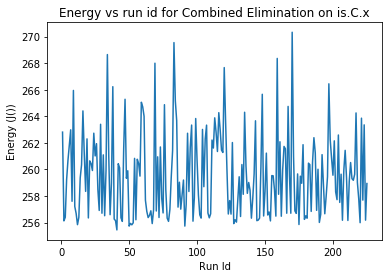

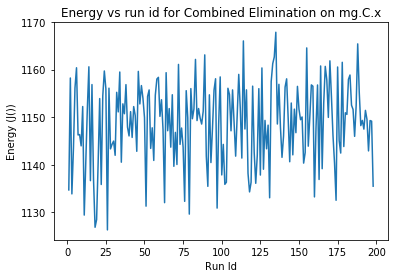

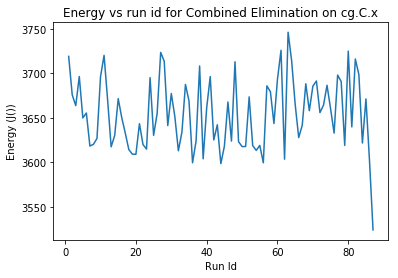

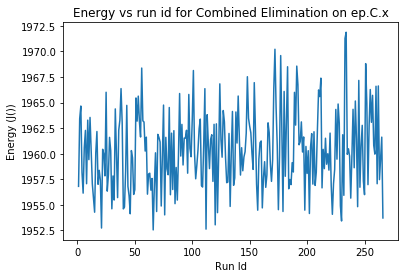

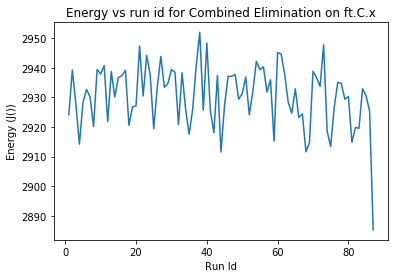

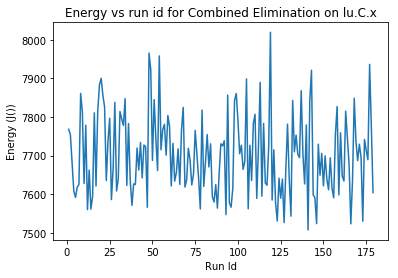

In [16]:
for benchmark in benchmarks:
    plot_energy_vs_runs(benchmark, average_data)

### Compare best improvement of Energy and time to O3 baseline

In [10]:
def o3_relative_data(average_data, benchmarks):
    o3_data = average_data.loc[average_data["Flags"] == "-O3"]
    
    relative_data = average_data.copy(deep=True)
    
    for benchmark in benchmarks:
        o3 = o3_data.loc[relative_data["Benchmark"] == benchmark]
        o3_energy = o3.iloc[0]["Energy"]
        o3_time = o3.iloc[0]["Time"]

        relative_data.loc[relative_data["Benchmark"] == benchmark, "Energy"] /= o3_energy
        relative_data.loc[relative_data["Benchmark"] == benchmark, "Time"] /= o3_time

    return relative_data


def plot_relative_to_o3(variable, relative_data, benchmarks):
    X = benchmarks
    Y = [relative_data.loc[relative_data["Benchmark"] == benchmark, variable].min() for benchmark in benchmarks]

    plt.figure()
    plt.scatter(X, Y, marker='x', label='CE')
    plt.axhline(1, label='O3')
    
    plt.title('Best relative improvement of ' + variable + ' relative to -O3')
    plt.ylabel(variable + ' (relative to -O3)')
    plt.legend()


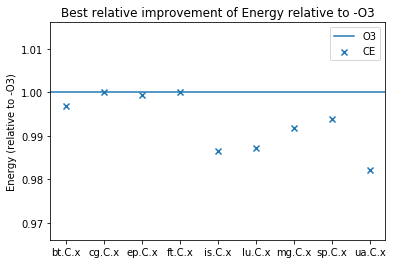

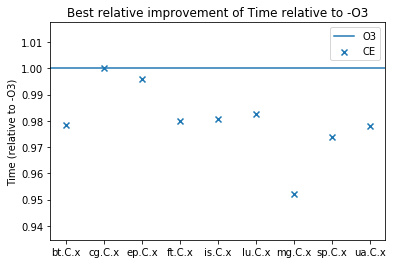

In [11]:
relative_data = o3_relative_data(average_data, benchmarks)
plot_relative_to_o3('Energy', relative_data, benchmarks)
plot_relative_to_o3('Time', relative_data, benchmarks)